# Freight PVAR

In [1]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import seaborn as sns
from scipy.stats import skew, pearsonr
import statsmodels.api as sm

### Load data

In [ ]:
## raw data
df = pd.read_stata("data/data_freight.dta")

## Post COVID
# df = pd.read_stata("data/data_post_covid.dta")

# Only when using data_frreight
df = df.drop(columns=['kma_ob_name', 'ST','distance_V', 'price_R', 'distance_R', 'price_F', 'distance_F', 'carrier_F', 'shipper_F', 'carrier_R', 'shipper_R'])
df = df.rename(columns={'kma': 'id', 'price_V': 'R', 'fuel': 'F', 'carrier_V': 'E', 'shipper_V': 'L'})

# Filter by year
df = df[df['year'] >= 2021].copy()
df.sort_values(by=['id', 'year', 'month'], inplace=True)
df.reset_index(drop=True, inplace=True)

df


,id,week,year,month,R,F,E,L
0,AZ_PHO,2021-01-01,2021,1,2.42,0.24,1763,6629
1,AZ_PHO,2021-01-08,2021,1,2.31,0.24,2370,7601
2,AZ_PHO,2021-01-15,2021,1,2.16,0.25,2343,10286
3,AZ_PHO,2021-01-22,2021,1,2.04,0.25,2274,11458
4,AZ_PHO,2021-01-29,2021,2,2.00,0.25,2485,7979
...,...,...,...,...,...,...,...,...
2995,WI_MIL,2022-10-29,2022,11,2.40,0.73,3979,13785
2996,WI_MIL,2022-11-05,2022,11,2.43,0.72,3831,12663
2997,WI_MIL,2022-11-12,2022,11,2.37,0.72,4049,13040
2998,WI_MIL,2022-11-19,2022,11,2.38,0.70,2695,7013


### Set date variables for PANEL estimation

In [167]:
# ensure week is datetime
df['week'] = pd.to_datetime(df['week'])

# extract month and year
df['day'] = df['week']
# df['month'] = df['day'].dt.month
# df['year'] = df['day'].dt.year

# drop 'day'
df = df.drop(columns=['day'])

df['t'] = (
    df.groupby('id', observed=False)['week']
      .transform(lambda x: (x - x.min()).dt.days // 7 + 1)
)

# reorder columns
df = df[['id', 't', 'week', 'month', 'year'] + [c for c in df.columns if c not in ['id','t','week','month','year']]]
df


,id,t,week,month,year,R,F,E,L
139,AZ_PHO,1,2021-01-01,1,2021,2.42,0.24,1763,6629
140,AZ_PHO,2,2021-01-08,1,2021,2.31,0.24,2370,7601
141,AZ_PHO,3,2021-01-15,1,2021,2.16,0.25,2343,10286
142,AZ_PHO,4,2021-01-22,1,2021,2.04,0.25,2274,11458
143,AZ_PHO,5,2021-01-29,2,2021,2.00,0.25,2485,7979
...,...,...,...,...,...,...,...,...,...
7165,WI_MIL,96,2022-10-29,11,2022,2.40,0.73,3979,13785
7166,WI_MIL,97,2022-11-05,11,2022,2.43,0.72,3831,12663
7167,WI_MIL,98,2022-11-12,11,2022,2.37,0.72,4049,13040
7168,WI_MIL,99,2022-11-19,11,2022,2.38,0.70,2695,7013


### Chart I - Freight Rate vs Equipment Posts (per KMA)

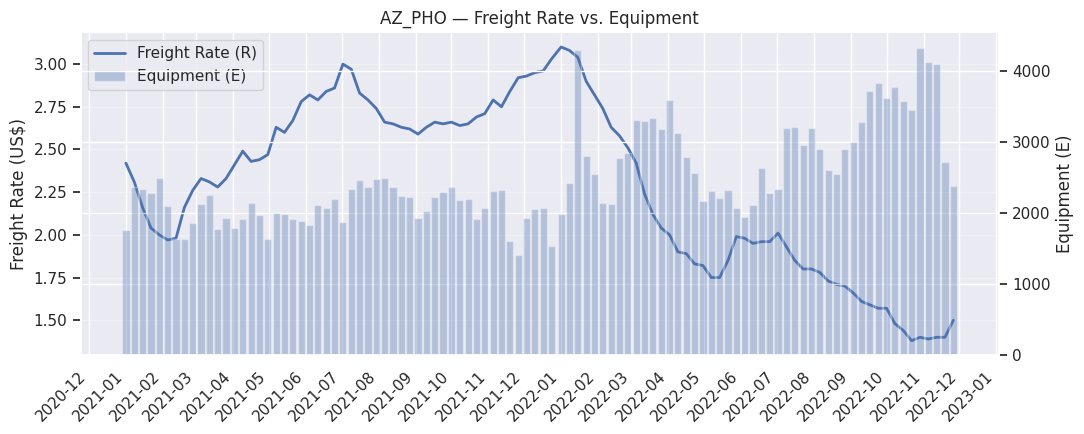

In [168]:
df_chart = df[df['id'] == 'AZ_PHO']
df_chart

# --- pick the ID and filter (your sample shows 'AZ_PHO')
kma_id = "AZ_PHO"
df_chart = (
    df.loc[df['id'] == kma_id, ['week', 'R', 'E']]
      .dropna(subset=['week'])
      .sort_values('week')
      .copy()
)

# create the plot
fig, ax1 = plt.subplots(figsize=(11, 4.5))

# left y-axis: R as line
ax1.plot(df_chart['week'], df_chart['R'], label='Freight Rate (R)', linewidth=2, zorder=3)
ax1.set_ylabel('Freight Rate (US$)')
ax1.grid(True, axis='y', alpha=0.3)

# right y-axis: E as bars
ax2 = ax1.twinx()
# width given in days when x is datetime; 6 keeps bars nearly a week wide
ax2.bar(df_chart['week'], df_chart['E'], width=6, alpha=0.35, label='Equipment (E)', zorder=1)
ax2.set_ylabel('Equipment (E)')

# x-axis formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# one legend combining both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

ax1.set_title(f"{kma_id} — Freight Rate vs. Equipment")
fig.tight_layout()
plt.show()


### Smothing Features and Capacity Ratio

In [ ]:
df = df.sort_values(['id', 't']).reset_index(drop=True)

# --- Helper: LOWESS per group, returns a Series aligned to original index
def lowess_per_group(g:pd.DataFrame, ycol: str, xcol: str = 't', frac: float = 0.15):
    x = g[xcol].to_numpy()
    y = g[ycol].to_numpy()
    mask = np.isfinite(x) & np.isfinite(y)
    out = pd.Series(np.nan, index=g.index)
    if mask.sum() >= 3:  # need a few points for smoothing
        sm = lowess(y[mask], x[mask], frac=frac, return_sorted=False)
        out.loc[g.index[mask]] = sm
    return out

# --- LOWESS smoothing of L and E by id (Stata: lowess ... bw(0.15))
df['L_smooth'] = df.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'L'))
df['E_smooth'] = df.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'E'))

# --- Replace L and E with ceil(smoothed) where available (Stata: replace ... ceil(tmp))
df.loc[df['L_smooth'].notna(), 'L'] = np.ceil(df.loc[df['L_smooth'].notna(), 'L_smooth'])
df.loc[df['E_smooth'].notna(), 'E'] = np.ceil(df.loc[df['E_smooth'].notna(), 'E_smooth'])

# Clean temp columns if you don't need them
df = df.drop(columns=['L_smooth', 'E_smooth'])

# --- C = L/E -> Compute CAPACITY Indicator
df['C'] = df['L'] / df['E']

# Comute logs, set to NaN if original value is <= 0
for col_src, col_out in [('R', 'r'), ('C', 'c'), ('F', 'f')]:
    valid = df[col_src] > 0
    df[col_out] = np.where(valid, np.log(df[col_src]), np.nan)

df


/tmp/ipykernel_23102/514582117.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['L_smooth'] = df.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'L'))
/tmp/ipykernel_23102/514582117.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['L_smooth'] = df.groupby('id', group_keys=False).apply(lambda g: lowess_per_group(g, 'L'))
/tmp/ipykernel_23102/514582117.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

,id,t,week,month,year,R,F,E,L,C,r,c,f
0,AZ_PHO,1,2021-01-01,1,2021,2.42,0.24,2288,7463,3.261801,0.883768,1.182279,-1.427116
1,AZ_PHO,2,2021-01-08,1,2021,2.31,0.24,2247,8073,3.592790,0.837248,1.278929,-1.427116
2,AZ_PHO,3,2021-01-15,1,2021,2.16,0.25,2206,8679,3.934270,0.770108,1.369725,-1.386294
3,AZ_PHO,4,2021-01-22,1,2021,2.04,0.25,2167,9286,4.285187,0.712950,1.455164,-1.386294
4,AZ_PHO,5,2021-01-29,2,2021,2.00,0.25,2131,9894,4.642891,0.693147,1.535337,-1.386294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,WI_MIL,96,2022-10-29,11,2022,2.40,0.73,3693,13390,3.625778,0.875469,1.288069,-0.314711
2996,WI_MIL,97,2022-11-05,11,2022,2.43,0.72,3692,13327,3.609697,0.887891,1.283624,-0.328504
2997,WI_MIL,98,2022-11-12,11,2022,2.37,0.72,3691,13264,3.593606,0.862890,1.279156,-0.328504
2998,WI_MIL,99,2022-11-19,11,2022,2.38,0.70,3687,13206,3.581774,0.867100,1.275858,-0.356675


### KAlman Filter to get smoothed values

In [169]:
df

,id,t,week,month,year,R,F,E,L
139,AZ_PHO,1,2021-01-01,1,2021,2.42,0.24,1763,6629
140,AZ_PHO,2,2021-01-08,1,2021,2.31,0.24,2370,7601
141,AZ_PHO,3,2021-01-15,1,2021,2.16,0.25,2343,10286
142,AZ_PHO,4,2021-01-22,1,2021,2.04,0.25,2274,11458
143,AZ_PHO,5,2021-01-29,2,2021,2.00,0.25,2485,7979
...,...,...,...,...,...,...,...,...,...
7165,WI_MIL,96,2022-10-29,11,2022,2.40,0.73,3979,13785
7166,WI_MIL,97,2022-11-05,11,2022,2.43,0.72,3831,12663
7167,WI_MIL,98,2022-11-12,11,2022,2.37,0.72,4049,13040
7168,WI_MIL,99,2022-11-19,11,2022,2.38,0.70,2695,7013


In [164]:
df

,id,t,week,month,year,R,F,E,L,C,...,_individual,_time,_NT,quarter,L1_r,L2_r,L1_c,L2_c,L1_f,c_trend
0,AZ_PHO,1,2021-01-01,1,2021,2.42,0.24,2288,7463,3.261801,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,2.266740
30,AZ_PHO,2,2021-01-08,1,2021,2.31,0.24,2247,8073,3.592790,...,0,1,1,1,0.883768,NaN,1.182279,NaN,-1.427116,2.252879
60,AZ_PHO,3,2021-01-15,1,2021,2.16,0.25,2206,8679,3.934270,...,0,2,2,1,0.837248,0.883768,1.278929,1.182279,-1.427116,2.239018
90,AZ_PHO,4,2021-01-22,1,2021,2.04,0.25,2167,9286,4.285187,...,0,3,3,1,0.770108,0.837248,1.369725,1.278929,-1.386294,2.225157
120,AZ_PHO,5,2021-01-29,2,2021,2.00,0.25,2131,9894,4.642891,...,0,4,4,1,0.712950,0.770108,1.455164,1.369725,-1.386294,2.211295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,WI_MIL,96,2022-10-29,11,2022,2.40,0.73,3693,13390,3.625778,...,29,95,2995,4,0.875469,0.896088,1.292370,1.299012,-0.314711,1.291733
2909,WI_MIL,97,2022-11-05,11,2022,2.43,0.72,3692,13327,3.609697,...,29,96,2996,4,0.875469,0.875469,1.288069,1.292370,-0.314711,1.290443
2939,WI_MIL,98,2022-11-12,11,2022,2.37,0.72,3691,13264,3.593606,...,29,97,2997,4,0.887891,0.875469,1.283624,1.288069,-0.328504,1.289153
2969,WI_MIL,99,2022-11-19,11,2022,2.38,0.70,3687,13206,3.581774,...,29,98,2998,4,0.862890,0.887891,1.279156,1.283624,-0.328504,1.287864


### Chart 2 - Histogram of feature distribution

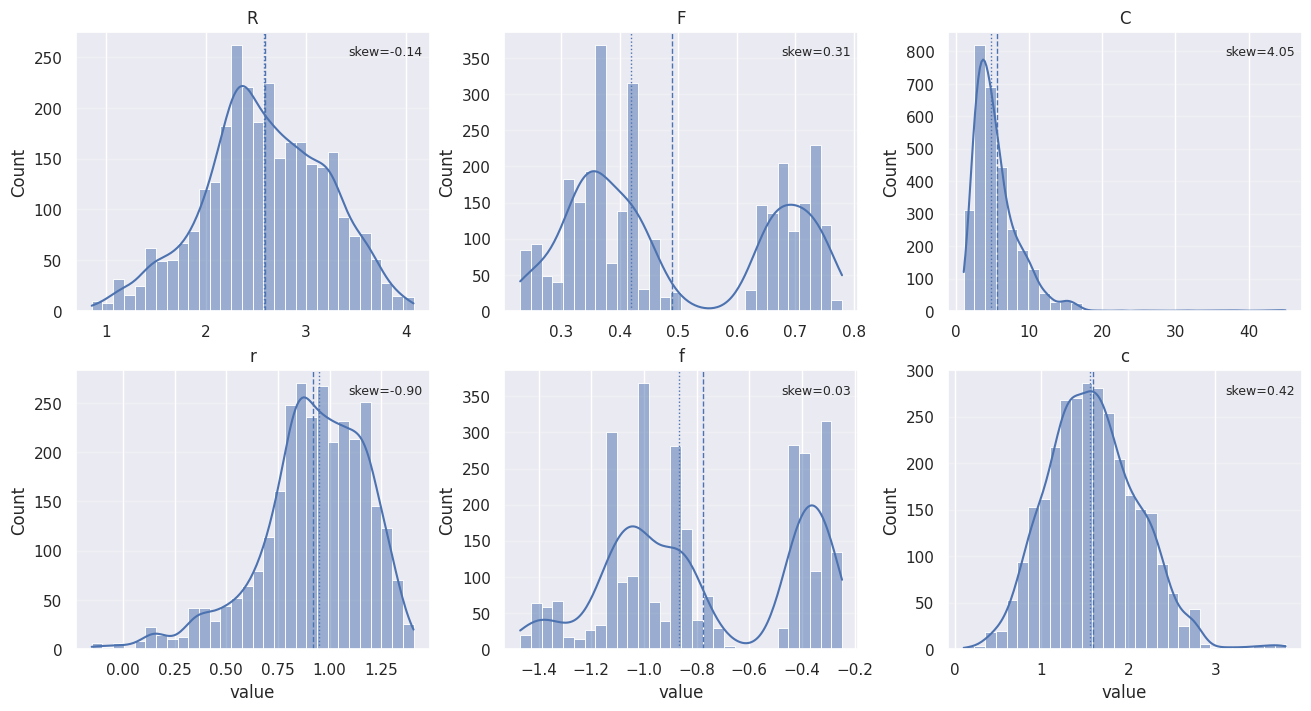

In [ ]:
sns.set_theme()

cols_top = ['R', 'F', 'C']
cols_bot = ['r', 'f', 'c']

fig, axes = plt.subplots(2, 3, figsize=(13, 7), constrained_layout=True)

def plot_hist(ax, s, title):
    s = pd.Series(s).dropna()
    sns.histplot(s, bins=30, kde=True, ax=ax)
    # mean/median
    m, md = s.mean(), s.median()
    ax.axvline(m, linestyle='--', linewidth=1)
    ax.axvline(md, linestyle=':',  linewidth=1)
    # annotate skewness
    ax.text(0.98, 0.95, f"skew={skew(s, nan_policy='omit'):.2f}",
            transform=ax.transAxes, ha='right', va='top', fontsize=9)
    ax.set_title(title)
    ax.grid(True, axis='y', alpha=0.25)

# top row: R, F, C
for j, col in enumerate(cols_top):
    plot_hist(axes[0, j], df[col], col)

# bottom row: r, f, c=
for j, col in enumerate(cols_bot):
    plot_hist(axes[1, j], df[col], col)

# nicer labels (optional)
for ax in axes[1]:
    ax.set_xlabel("value")
for ax in axes[0]:
    ax.set_xlabel("")

plt.show()


### Chart 3 - Freight Rate vs Capacity Ratio (per KMA)

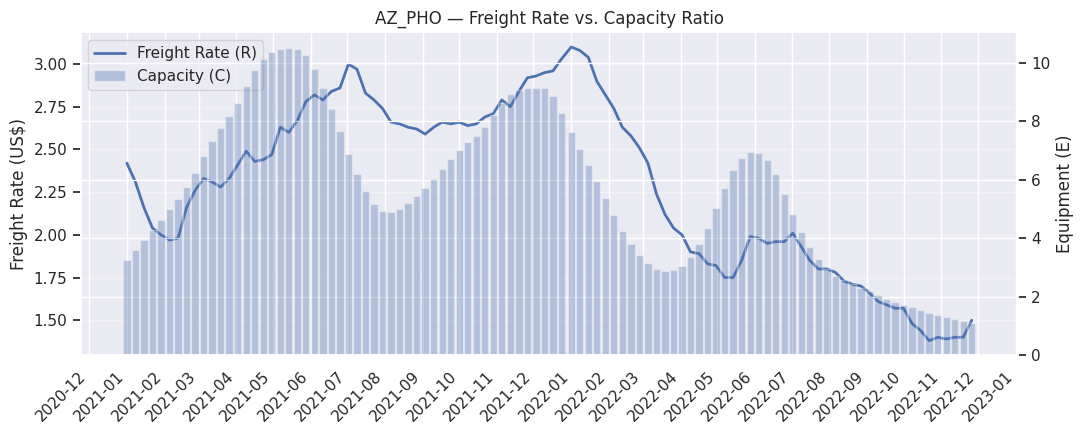

In [112]:
df_chart = df[df['id'] == 'AZ_PHO']
df_chart

# --- pick the ID and filter (your sample shows 'AZ_PHO')
kma_id = "AZ_PHO"
df_chart = (
    df.loc[df['id'] == kma_id, ['week', 'R', 'C']]
      .dropna(subset=['week'])
      .sort_values('week')
      .copy()
)

# create the plot
fig, ax1 = plt.subplots(figsize=(11, 4.5))

# left y-axis: R as line
ax1.plot(df_chart['week'], df_chart['R'], label='Freight Rate (R)', linewidth=2, zorder=3)
ax1.set_ylabel('Freight Rate (US$)')
ax1.grid(True, axis='y', alpha=0.3)

# right y-axis: E as bars
ax2 = ax1.twinx()
# width given in days when x is datetime; 6 keeps bars nearly a week wide
ax2.bar(df_chart['week'], df_chart['C'], width=6, alpha=0.35, label='Capacity (C)', zorder=1)
ax2.set_ylabel('Equipment (E)')

# x-axis formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# one legend combining both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

ax1.set_title(f"{kma_id} — Freight Rate vs. Capacity Ratio")
fig.tight_layout()
plt.show()


### Chart 4 - Scatter plots - relating features

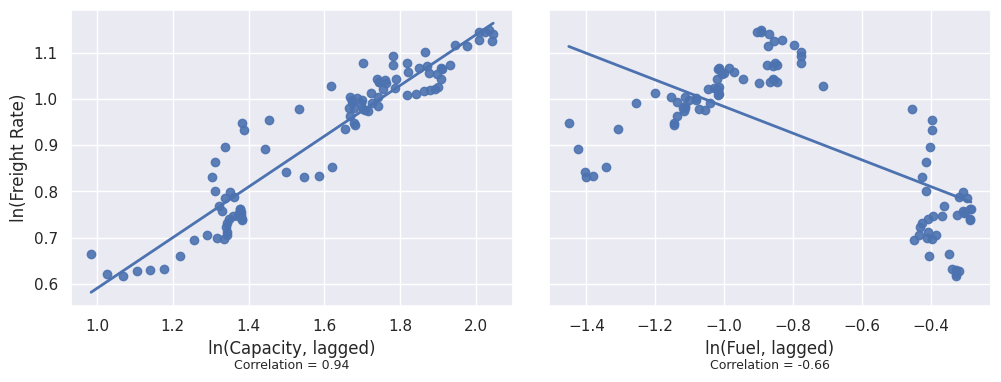

In [113]:
df = df.sort_values(['t', 'id']).reset_index(drop=True)

# --- Logs (guard against non-positive values)
for src, dst in [('R','lnR'), ('F','lnF'), ('C','lnC')]:
    valid = df[src] > 0
    df[dst] = np.where(valid, np.log(df[src]), np.nan)

# --- Cross-section means by time t
means_t = (
    df.groupby('t')[['lnR', 'lnC', 'lnF']]
      .mean()
      .sort_index()
      .rename(columns={'lnR': 'lnR_m', 'lnC': 'lnC_m', 'lnF': 'lnF_m'})
)

# 1-period lag of time-means
means_t['L_lnC_m'] = means_t['lnC_m'].shift(1)
means_t['L_lnF_m'] = means_t['lnF_m'].shift(1)

# Data for each subplot (drop missing)
plot_c = means_t[['lnR_m', 'L_lnC_m']].dropna().rename(columns={'L_lnC_m': 'x'})
plot_f = means_t[['lnR_m', 'L_lnF_m']].dropna().rename(columns={'L_lnF_m': 'x'})

# Plot chart 
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0.08, bottom=0.12) 

# panel data
pairs = [
    (plot_c, "ln(Capacity, lagged)", axes[0]),
    (plot_f, "ln(Fuel, lagged)",    axes[1]),
]

for data, xlabel, ax in pairs:
    sns.regplot(data=data, x='x', y='lnR_m', ci=None,
                scatter_kws={'s': 36, 'alpha': 0.9},
                line_kws={'linewidth': 2}, ax=ax)
    ax.set_xlabel(xlabel)

    # Pearson correlation (dropna already done in plot_* frames)
    r, p = pearsonr(data['x'], data['lnR_m'])

    # put text BELOW the x-axis; (-0.18) is below the axis in Axes coords
    ax.text(0.5, -0.18, f"Correlation = {r:.2f}",
            transform=ax.transAxes, ha='center', va='top', fontsize=9)

# labels / cosmetics
axes[0].set_ylabel("ln(Freight Rate)")
axes[1].set_ylabel("")
# for ax in axes:
#     ax.set_box_aspect(None) 
    # ax.set_box_aspect(1)

# tighten spacing & margins (no tight_layout())
fig.subplots_adjust(left=0.07, right=0.99, top=0.96, bottom=0.22, wspace=0.08)

plt.show()


## Panel VARX Estimation

### Intuition
* Estimate two equations (endogenous variables) and then build a VAR(2) system from them.

* With two endogenous variables $y_{it} = \begin{bmatrix} r_{it} \\ c_{it} \end{bmatrix}$ and lag order 2, a PVAR(2) is:


$$
\begin{bmatrix} r_{it} \\ c_{it} \end{bmatrix}
=
A_1 \begin{bmatrix} r_{i,t-1} \\ c_{i,t-1} \end{bmatrix}
+
A_2 \begin{bmatrix} r_{i,t-2} \\ c_{i,t-2} \end{bmatrix}
+
B\,x_{it} + \alpha_i + \tau_t + u_{it}.
$$

- $(A_1, A_2)$ capture **own** and **cross** lag effects (the VAR dynamics).
- $(x_{it})$ are **exogenous** controls (e.g., $(f_t, f_{t-1})$).
- $(\alpha_i)$ are unit fixed effects; $(\tau_t)$ are time dummies.
- In a **panel** VAR we pool coefficients across \(i\) and typically use panel GMM to handle endogeneity of lagged \(y\).

Written as two separate equations (the rows of the system):

$$
\begin{aligned}
r_{it} &= a_{11}^{(1)} r_{i,t-1} + a_{12}^{(1)} c_{i,t-1}
        + a_{11}^{(2)} r_{i,t-2} + a_{12}^{(2)} c_{i,t-2}
        + \beta_r^\top x_{it} + \alpha_i^{r} + \tau_t^{r} + u_{it}^{r},\\[4pt]
c_{it} &= a_{21}^{(1)} r_{i,t-1} + a_{22}^{(1)} c_{i,t-1}
        + a_{21}^{(2)} r_{i,t-2} + a_{22}^{(2)} c_{i,t-2}
        + \beta_c^\top x_{it} + \alpha_i^{c} + \tau_t^{c} + u_{it}^{c}.
\end{aligned}
$$


That’s why a PVAR with $[r,c]$ has **two equations**: one with $r_{it}$ as the dependent variable and one with $(c_{it})$. Each equation provides one **row** of $(A_1)$ and $(A_2)$.


#### Post-estimation tests: What to monitor after each run:

* **instruments (aim ≤ # groups; your table shows 30 groups KMAs).**

* Hansen p-value ⇒ should be finite and not extreme (avoid ~1.00 or ~0.00).

* Arellano–Bond ⇒ AR(1) p < 0.05 (expected), AR(2) p > 0.10.


## Baseline Model - Full Model

In [114]:
import numpy as np
np.NaN = np.nan 
from pydynpd import regression

df = df.sort_values(['id','t']).copy()

# pydynpd expects concrete ids and an integer-ish time index
df['t'] = df['t'].astype(int)

# Compute Equations
# Equation for r_t  (lags of r and c, exog f and L1.f)
cmd_r = 'r L(1:2).r L(1:2).c f L1.f | gmm(r, 2:5) gmm(c, 2:5) iv(f L1.f) | timedumm nolevel'
res_r = regression.abond(cmd_r, df, ['id','t'])

# Equation for c_t  (symmetric)
cmd_c = 'c L(1:2).r L(1:2).c f L1.f | gmm(r, 2:5) gmm(c, 2:5) iv(f L1.f) | timedumm nolevel'
res_c = regression.abond(cmd_c, df, ['id','t'])

# Look at results (tables include Hansen J and AB AR(1)/AR(2) tests)
print(res_r)   # r-equation summary
print(res_c)   # c-equation summary

# Get VAR (2) coefficient matrices A1, A2 from the two regressions
def coef(model, name, default=0.0):
    tbl = model.models[0].regression_table.set_index('variable')
    return float(tbl.loc[name, 'coefficient']) if name in tbl.index else default

A1 = np.array([[coef(res_r, 'L1.r'), coef(res_r, 'L1.c')],
               [coef(res_c, 'L1.r'), coef(res_c, 'L1.c')]])
A2 = np.array([[coef(res_r, 'L2.r'), coef(res_r, 'L2.c')],
               [coef(res_c, 'L2.r'), coef(res_c, 'L2.c')]])
print(A1)

# companion matrix & stability (like pvarstable)
k = 2
companion = np.block([[A1, A2],
                      [np.eye(k), np.zeros((k, k))]])
eigvals = np.linalg.eigvals(companion)
print("Eigenvalues:", eigvals)
print("Stable (all |λ|<1)?", np.all(np.abs(eigvals) < 1))


 Dynamic panel-data estimation, two-step difference GMM
 Group variable: id                                Number of obs = 2910     
 Time variable: t                                  Min obs per group: 97    
 Number of instruments = 869                       Max obs per group: 97    
 Number of groups = 30                             Avg obs per group: 97.00 
+-------+------------+---------------------+------------+-----------+-----+
|   r   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+-------+------------+---------------------+------------+-----------+-----+
|  L1.r | -0.0006943 |      0.0004869      | -1.4259662 | 0.1538781 |     |
|  L2.r | -0.0020324 |      0.0004314      | -4.7115213 | 0.0000025 | *** |
|  L1.c | 0.0007234  |      0.0001490      | 4.8552978  | 0.0000012 | *** |
|  L2.c | 0.0003140  |      0.0001032      | 3.0416469  | 0.0023529 |  ** |
|   f   | -0.0022985 |      0.0004840      | -4.7493292 | 0.0000020 | *** |
|  L1.f | -0.0000795 |      

## Model 2 - Drop instruments - Hansem test is bad

### Collapse Instruments (Roodman, 2009)
### Model 2.1 -  Keep weekly time dummies, but collapse and shorten the window

In [115]:
# diff-GMM (no level eq.), collapsed instruments, shorter windows (2:3)
cmd_r = 'r L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f) | timedumm nolevel collapse'
res_r = regression.abond(cmd_r, df, ['id','t'])

cmd_c = 'c L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f) | timedumm nolevel collapse'
res_c = regression.abond(cmd_c, df, ['id','t'])

print(res_r)   # r-equation summary
print(res_c)   # c-equation summary


 Dynamic panel-data estimation, two-step difference GMM
 Group variable: id                                Number of obs = 2910     
 Time variable: t                                  Min obs per group: 97    
 Number of instruments = 103                       Max obs per group: 97    
 Number of groups = 30                             Avg obs per group: 97.00 
+-------+------------+---------------------+-------------+-----------+-----+
|   r   |   coef.    | Corrected Std. Err. |      z      |   P>|z|   |     |
+-------+------------+---------------------+-------------+-----------+-----+
|  L1.r | 0.0055225  |      0.0004184      |  13.1984123 | 0.0000000 | *** |
|  L2.r | 0.0060187  |      0.0003527      |  17.0631018 | 0.0000000 | *** |
|  L1.c | 0.0175328  |      0.0008066      |  21.7375047 | 0.0000000 | *** |
|  L2.c | 0.0111624  |      0.0005213      |  21.4115962 | 0.0000000 | *** |
|   f   | -0.0363323 |      0.0016724      | -21.7246632 | 0.0000000 | *** |
|  L1.f | -0.0353043

### Model 2.2 - — Drop weekly dummies

In [118]:
cmd_r = 'r L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f) |  collapse'
res_r = regression.abond(cmd_r, df, ['id','t'])

cmd_c = 'c L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f) |  collapse'
res_c = regression.abond(cmd_c, df, ['id','t'])

# Look at results (tables include Hansen J and AB AR(1)/AR(2) tests)
print(res_r)   # r-equation summary
print(res_c)   # c-equation summary

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                              Number of obs = 2910     
 Time variable: t                                Min obs per group: 97    
 Number of instruments = 9                       Max obs per group: 97    
 Number of groups = 30                           Avg obs per group: 97.00 
+------+------------+---------------------+------------+-----------+-----+
|  r   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.r | 1.2640130  |      0.0819192      | 15.4299967 | 0.0000000 | *** |
| L2.r | -0.4982661 |      0.1001996      | -4.9727331 | 0.0000007 | *** |
| L1.c | -0.1040149 |      0.0423507      | -2.4560366 | 0.0140479 |  *  |
| L2.c | 0.1430182  |      0.0437327      | 3.2702813  | 0.0010744 |  ** |
|  f   | -0.1088067 |      0.0208348      | -5.2223565 | 0.0000002 | *** |
| L1.f | 0.0491191  |      0.0157250      | 3.12

### Model 2.3 - Monthly instruments

In [ ]:
# build coarse time FE
dummies = pd.get_dummies(df[['month']].astype('category'),
                         drop_first=True, prefix=['m'])
df_fe = pd.concat([df, dummies], axis=1)
iv_fe = ' '.join(dummies.columns)  # space-separated list

cmd_r = f'r L(1:2).r L(1:2).c f  {iv_fe} | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f {iv_fe}) |  collapse'
res_r = regression.abond(cmd_r, df_fe, ['id','t'])

cmd_c = f'c L(1:2).r L(1:2).c f  {iv_fe} | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f {iv_fe}) |  collapse'
res_c = regression.abond(cmd_c, df_fe, ['id','t'])

print(res_r)   # r-equation summary
print(res_c)   # c-equation summary


 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                               Number of obs = 2910     
 Time variable: t                                 Min obs per group: 97    
 Number of instruments = 20                       Max obs per group: 97    
 Number of groups = 30                            Avg obs per group: 97.00 
+------+------------+---------------------+------------+-----------+-----+
|  r   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.r | 1.2259766  |      0.0606323      | 20.2198671 | 0.0000000 | *** |
| L2.r | -0.3962865 |      0.0691684      | -5.7292976 | 0.0000000 | *** |
| L1.c | -0.0567492 |      0.0432637      | -1.3117050 | 0.1896197 |     |
| L2.c | 0.0966779  |      0.0462044      | 2.0923985  | 0.0364029 |  *  |
|  f   | -0.0418725 |      0.0093811      | -4.4635037 | 0.0000081 | *** |
| m_2  | 0.0151768  |      0.0034349      | 

### Model 2.4 - Quartely instruments

In [141]:
df['quarter'] = ((df['month']-1)//3 + 1).astype('int')
dummies = pd.get_dummies(df[['quarter']].astype('category'),
                         drop_first=True, prefix=['q'])
df_fe = pd.concat([df, dummies], axis=1)
iv_fe = ' '.join(dummies.columns)

cmd_r = f'r L(1:2).r L(1:2).c f  {iv_fe} | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f {iv_fe}) |  collapse'
res_r = regression.abond(cmd_r, df_fe, ['id','t'])

cmd_c = f'c L(1:2).r L(1:2).c f {iv_fe} | gmm(r, 2:3) gmm(c, 2:3) iv(f L1.f {iv_fe}) | collapse'
res_c = regression.abond(cmd_c, df_fe, ['id','t'])

print(res_r) 
print(res_c) 

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                               Number of obs = 2910     
 Time variable: t                                 Min obs per group: 97    
 Number of instruments = 12                       Max obs per group: 97    
 Number of groups = 30                            Avg obs per group: 97.00 
+------+------------+---------------------+------------+-----------+-----+
|  r   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.r | 1.2240696  |      0.0702810      | 17.4167852 | 0.0000000 | *** |
| L2.r | -0.4484998 |      0.0822001      | -5.4561955 | 0.0000000 | *** |
| L1.c | -0.0889262 |      0.0384168      | -2.3147727 | 0.0206254 |  *  |
| L2.c | 0.1303218  |      0.0402070      | 3.2412716  | 0.0011900 |  ** |
|  f   | -0.0571857 |      0.0081135      | -7.0482208 | 0.0000000 | *** |
| q_2  | 0.0012302  |      0.0040544      | 

In [91]:
df = df[df['year'] >= 2021].copy()

In [125]:
df['quarter'] = ((df['month']-1)//3 + 1).astype('int')
dummies = pd.get_dummies(df[['quarter']].astype('category'),
                         drop_first=True, prefix=['q'])
df_fe = pd.concat([df, dummies], axis=1)
iv_fe = ' '.join(dummies.columns)

cmd_r = f'r L(1:2).r L(1:2).c f L1.f {iv_fe} | gmm(r, 2:3) gmm(c, 2:2) iv(f L1.f {iv_fe}) |  collapse'
res_r = regression.abond(cmd_r, df_fe, ['id','t'])

cmd_c = f'c L(1:2).r L(1:2).c f L1.f {iv_fe} | gmm(r, 2:2) gmm(c, 2:2) iv(f L1.f {iv_fe}) |  collapse'
res_c = regression.abond(cmd_c, df_fe, ['id','t'])

print(res_r) 
print(res_c) 

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                               Number of obs = 2910     
 Time variable: t                                 Min obs per group: 97    
 Number of instruments = 11                       Max obs per group: 97    
 Number of groups = 30                            Avg obs per group: 97.00 
+------+------------+---------------------+------------+-----------+-----+
|  r   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.r | -0.2941268 |      0.5502393      | -0.5345434 | 0.5929656 |     |
| L2.r | -0.0335611 |      0.1430831      | -0.2345569 | 0.8145527 |     |
| L1.c | -0.5809990 |      0.1842717      | -3.1529477 | 0.0016163 |  ** |
| L2.c | 1.0467794  |      0.3316462      | 3.1563134  | 0.0015978 |  ** |
|  f   | -0.0309093 |      0.0377113      | -0.8196304 | 0.4124268 |     |
| L1.f | -0.1507613 |      0.0824550      | 

In [133]:
cmd_r = 'r L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3) | collapse'
res_r = regression.abond(cmd_r, df, ['id','t'])

cmd_c = 'c L(1:2).r L(1:2).c f L1.f | gmm(r, 2:3) gmm(c, 2:3)  | collapse'
res_c = regression.abond(cmd_c, df, ['id','t'])

# Look at results (tables include Hansen J and AB AR(1)/AR(2) tests)
print(res_r)   # r-equation summary
print(res_c)   # c-equation summary

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                              Number of obs = 2910     
 Time variable: t                                Min obs per group: 97    
 Number of instruments = 9                       Max obs per group: 97    
 Number of groups = 30                           Avg obs per group: 97.00 
+------+------------+---------------------+------------+-----------+-----+
|  r   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.r | 1.2640130  |      0.0819192      | 15.4299967 | 0.0000000 | *** |
| L2.r | -0.4982661 |      0.1001996      | -4.9727331 | 0.0000007 | *** |
| L1.c | -0.1040149 |      0.0423507      | -2.4560366 | 0.0140479 |  *  |
| L2.c | 0.1430182  |      0.0437327      | 3.2702813  | 0.0010744 |  ** |
|  f   | -0.1088067 |      0.0208348      | -5.2223565 | 0.0000002 | *** |
| L1.f | 0.0491191  |      0.0157250      | 3.12

## VAR Stability Test

Eigenvalues: [ 0.22847852+0.j          0.00306494+0.07337344j  0.00306494-0.07337344j
 -0.15429314+0.j        ]


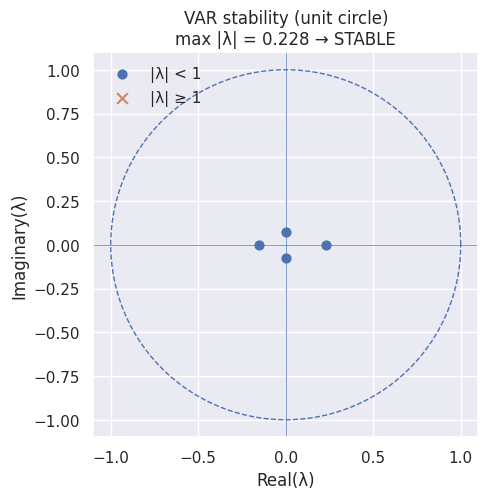

In [46]:
def plot_unit_circle(eigvals, title="VAR stability (unit circle)", tol=1e-10):
    eigvals = np.asarray(eigvals)
    mods = np.abs(eigvals)
    stable_mask = mods < (1 - tol)

    fig, ax = plt.subplots(figsize=(5,5))

    # unit circle
    t = np.linspace(0, 2*np.pi, 400)
    ax.plot(np.cos(t), np.sin(t), linestyle='--', linewidth=1)

    # axes
    ax.axhline(0, lw=0.5)
    ax.axvline(0, lw=0.5)

    # eigenvalues
    ax.scatter(eigvals.real[stable_mask], eigvals.imag[stable_mask], s=40, label='|λ| < 1')
    ax.scatter(eigvals.real[~stable_mask], eigvals.imag[~stable_mask], s=60, marker='x', label='|λ| ≥ 1')

    # limits & labels
    lim = 1.1 * max(1.0, mods.max())
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Real(λ)')
    ax.set_ylabel('Imaginary(λ)')
    ax.set_title(f"{title}\nmax |λ| = {mods.max():.3f} → "
                 f"{'STABLE' if stable_mask.all() else 'UNSTABLE'}")
    ax.legend(loc='upper left', frameon=False)
    plt.show()

# Example using your companion matrix:
eigvals = np.linalg.eigvals(companion)
print("Eigenvalues:", eigvals)
plot_unit_circle(eigvals)


* All the eigenvalues lie inside the unit circle.
* VAR satisfies stability condition.


## Compute IRF Functions

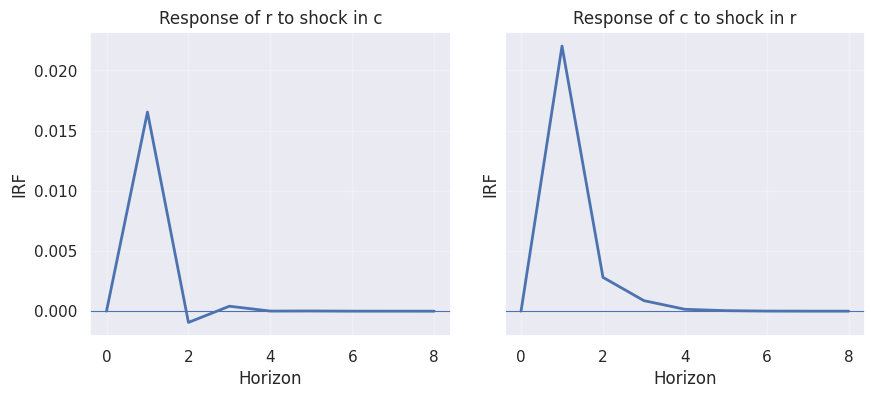

In [30]:

# ---- Build MA(∞) coefficients Ψ_h from VAR(p) ----
def ma_coefs(A_list, H):
    """A_list = [A1, A2, ..., Ap], each k×k. Returns Ψ[0..H], each k×k."""
    k = A_list[0].shape[0]
    p = len(A_list)
    Psi = [np.eye(k)]
    for h in range(1, H+1):
        S = np.zeros((k, k))
        for ell in range(1, min(p, h) + 1):
            S += Psi[h-ell] @ A_list[ell-1]
        Psi.append(S)
    return Psi  # length H+1

# ---- IRF calculator ----
def compute_irf(A_list, H=12, Sigma=None, method="chol"):
    """
    method: 'chol' (orthogonalized) or 'generalized' (Pesaran–Shin).
    Returns array IRF[h, i, j] = response of variable i to shock in j at horizon h.
    """
    k = A_list[0].shape[0]
    Psi = ma_coefs(A_list, H)
    if Sigma is None:
        Sigma = np.eye(k)

    if method == "chol":
        # orthogonalized 1-s.d. shocks: P @ P' = Sigma
        # If Sigma not PD, small ridge helps
        try:
            P = np.linalg.cholesky(Sigma)
        except np.linalg.LinAlgError:
            P = np.linalg.cholesky(Sigma + 1e-10 * np.eye(k))
        IRF = np.stack([Psi[h] @ P for h in range(H+1)], axis=0)

    elif method == "generalized":
        # GIRF: IRF_h(i,j) = e_i' Ψ_h Σ e_j / sqrt(e_j' Σ e_j)
        denom = np.sqrt(np.diag(Sigma))  # std of reduced-form shocks
        IRF = np.zeros((H+1, k, k))
        for h in range(H+1):
            A = Psi[h] @ Sigma
            for j in range(k):
                IRF[h, :, j] = A[:, j] / (denom[j] if denom[j] > 0 else 1.0)
    else:
        raise ValueError("method must be 'chol' or 'generalized'")
    return IRF  # shape (H+1, k, k)

# ---- Try to estimate Σu from your AB results (fallback: identity) ----
def residual_covariance_or_I(res_r, res_c):
    try:
        e_r = np.asarray(res_r.models[0].residuals).ravel()
        e_c = np.asarray(res_c.models[0].residuals).ravel()
        n = min(len(e_r), len(e_c))
        return np.cov(np.vstack([e_r[:n], e_c[:n]]))
    except Exception:
        return np.eye(2)


# horizon
H = 8

# residual covariance (fallback to I if unavailable)
Sigma = residual_covariance_or_I(res_r, res_c)

# choose 'chol' (order matters: variables are [r, c]) or 'generalized'
IRF = compute_irf([A1, A2], H=H, Sigma=Sigma, method="chol")

t = np.arange(H + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# r response to c shock
axes[0].plot(t, IRF[:, 0, 1], lw=2)
axes[0].axhline(0, lw=0.8)
axes[0].set_title("Response of r to shock in c")
axes[0].set_xlabel("Horizon")
axes[0].set_ylabel("IRF")
axes[0].grid(alpha=0.25)

# c response to r shock
axes[1].plot(t, IRF[:, 1, 0], lw=2)
axes[1].axhline(0, lw=0.8)
axes[1].set_title("Response of c to shock in r")
axes[1].set_xlabel("Horizon")
axes[1].set_ylabel("IRF")
axes[1].grid(alpha=0.25)

fig.subplots_adjust(wspace=0.15, bottom=0.12)
plt.show()


In [142]:
import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

# --- prep
df = df.sort_values(['id','t']).copy()
# create lags by id
for col, Ls in [('r',[1,2]), ('c',[1,2]), ('f',[1])]:
    for L in Ls:
        df[f'L{L}_{col}'] = df.groupby('id')[col].shift(L)

# keep rows with full set of regressors
need = ['r','c','f','L1_r','L2_r','L1_c','L2_c','L1_f']
df2 = df.dropna(subset=need).copy()

# panel index
panel = df2.set_index(['id','t'])

# --- VARX(2) via FE-OLS (entity + time effects), clustered SEs
X_r = panel[['L1_r','L2_r','L1_c','L2_c','f','L1_f']]
y_r = panel['r']
res_r = PanelOLS(y_r, X_r, entity_effects=True, time_effects=True)\
          .fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

X_c = panel[['L1_r','L2_r','L1_c','L2_c','f','L1_f']]
y_c = panel['c']
res_c = PanelOLS(y_c, X_c, entity_effects=True, time_effects=True)\
          .fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

print(res_r.summary)
print(res_c.summary)

# --- Build VAR(2) coefficient matrices A1, A2 (VARX ignores exogenous for A's)
def b(res, name): return float(res.params.get(name, 0.0))

A1 = np.array([[b(res_r,'L1_r'), b(res_r,'L1_c')],
               [b(res_c,'L1_r'), b(res_c,'L1_c')]])

A2 = np.array([[b(res_r,'L2_r'), b(res_r,'L2_c')],
               [b(res_c,'L2_r'), b(res_c,'L2_c')]])

print("A1:\n", A1)
print("A2:\n", A2)

# --- Stability (unit-circle / companion)
k = 2
companion = np.block([[A1, A2],
                      [np.eye(k), np.zeros((k,k))]])
eigvals = np.linalg.eigvals(companion)
print("Eigenvalues:", eigvals)
print("Stable (all |λ|<1)?", np.all(np.abs(eigvals) < 1))
print("Companion matrix:\n", companion)


/tmp/ipykernel_23102/3603616983.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'L{L}_{col}'] = df.groupby('id')[col].shift(L)
/tmp/ipykernel_23102/3603616983.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'L{L}_{col}'] = df.groupby('id')[col].shift(L)
/tmp/ipykernel_23102/3603616983.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'L{L}_{col}'] = df.groupby('id')[col].shift(L)
/tmp/ipykernel_2

                          PanelOLS Estimation Summary                           
Dep. Variable:                      r   R-squared:                        0.9230
Estimator:                   PanelOLS   R-squared (Between):              0.9951
No. Observations:                2940   R-squared (Within):               0.9673
Date:                Mon, Sep 15 2025   R-squared (Overall):              0.9943
Time:                        16:16:45   Log-likelihood                    8065.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5611.4
Entities:                          30   P-value                           0.0000
Avg Obs:                       98.000   Distribution:                  F(6,2807)
Min Obs:                       98.000                                           
Max Obs:                       98.000   F-statistic (robust):             1164.3
                            

In [146]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [ ]:
# ---------- 1) Build a single multivariate time series ----------
# r = ln(R), c = ln(C), f = ln(F) should already exist
ts = (
    df.sort_values('t')
      .groupby('t')[['r', 'c', 'f']]
      .mean()
      .dropna()
      .copy()
)

# include a lag of f as exogenous too
ts['L1_f'] = ts['f'].shift(1)
ts = ts.dropna()

endog = ts[['r','c']]
# exog =  ts[['f']] 
exog  = ts[['f','L1_f']]  

# ---------- 2) Fit VARMAX(p, q) with exogenous (use q=0, pure VARX) ----------
best = None
for p in (1,2,3,4):              # small search over AR order
    try:
        mod = sm.tsa.VARMAX(endog, order=(p, 0), exog=exog,
                            trend='c', enforce_stationarity=True, enforce_invertibility=True)
        res = mod.fit(disp=False, maxiter=1000)
        if (best is None) or (res.aic < best[0]):
            best = (res.aic, p, res)
    except Exception as e:
        pass

aic, p, res = best
print(f"Selected VARMAX({p},0) by AIC={aic:.2f}")
print(res.summary())


/home/max/projects/Diversos/Freight_Paper/venv_freight/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/max/projects/Diversos/Freight_Paper/venv_freight/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/max/projects/Diversos/Freight_Paper/venv_freight/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/max/projects/Diversos/Freight_Paper/venv_freight/lib/python3.12/site-packages/

Selected VARMAX(4,0) by AIC=-1162.66
                           Statespace Model Results                           
Dep. Variable:             ['r', 'c']   No. Observations:                   99
Model:                        VARX(4)   Log Likelihood                 606.330
                          + intercept   AIC                          -1162.660
Date:                Mon, 15 Sep 2025   BIC                          -1097.782
Time:                        16:47:02   HQIC                         -1136.411
Sample:                             0                                         
                                 - 99                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             3.65, 7.31   Jarque-Bera (JB):         62.21, 18.36
Prob(Q):                        0.06, 0.01   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.75, 0.49   Skew:                      1.30, -0.47
